In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [76]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.

# define PCA
pca = PCA()

# define the classifier
logistic = LogisticRegression(max_iter=10000, tol=0.1)

# define the pipeline
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# define the dataset
X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Set the pipeline parameters (separated with '__')
param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}

# define the grid search process
search = GridSearchCV(pipe, param_grid, n_jobs=-1)

# fit the grid search process
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.922):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 40}


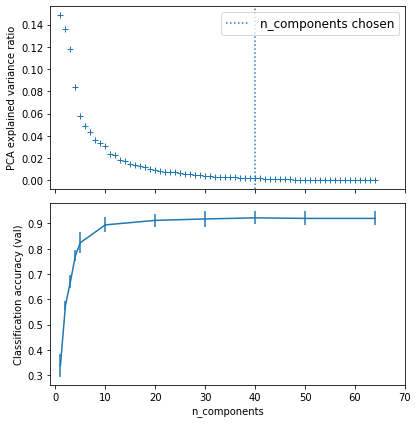

In [77]:
# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

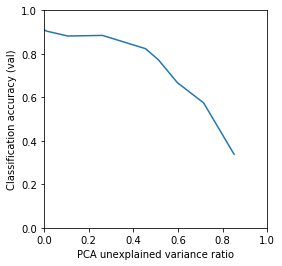

In [78]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(4, 4))
cv_results = search.cv_results_['mean_test_score'].reshape(4,len(param_grid['pca__n_components']))
arg_C_best = cv_results.mean(1).argmax()
results_pca_comp = cv_results[2]
tot_explained_variance = pca.explained_variance_ratio_.cumsum()\
                            [np.array(param_grid['pca__n_components'])-1]

ax0.plot(1-tot_explained_variance,results_pca_comp)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1);
ax0.set_ylabel('Classification accuracy (val)')
ax0.set_xlabel('PCA unexplained variance ratio');